In [1]:
from datetime import datetime
from operator import itemgetter
import os
import os.path
import re
from urllib.request import urlopen

import matplotlib.colors as colors
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
populations_url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population'
mortalities_url = 'https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependent_territories_by_mortality_rate'
coronavirus_url = 'https://en.wikipedia.org/wiki/2019%E2%80%9320_coronavirus_pandemic_deaths/WHO_situation_reports'

populations_headings = ['Rank', 'Country (or dependent territory)', 'Population']
populations_country = populations_headings[1]
populations_data = populations_headings[2]
mortalities_headings = ['Country/Territory', 'OECD 2011', 'OECD 2011.1', 'CIA WF 2017', 'CIA WF 2017.1']
mortalities_country = mortalities_headings[0]
mortalities_data = mortalities_headings[3]
coronavirus_headings = ['Date', 'First reported case']
coronavirus_country = coronavirus_headings[0]
coronavirus_start_as_text = coronavirus_headings[1]
coronavirus_start = '___start'
coronavirus_days_since = '___days_since_start'

coronavirus_countries_translations = { 
      'usa' : 'united states', 
      'uk' : 'united kingdom', 
      'uae' : 'united arab emirates',
      'drc' : 'dr congo',
    }


def get_html_from_url(url):
    with urlopen(url) as page:
        html_bytes = page.read()
        html_text = html_bytes.decode('utf-8')
        return html_text
    
def get_html_tables(html, headings, last=False, all_tables=False):
    tables = pd.read_html(html, header=0)
    tables = reversed(tables) if last else tables
    selected_tables = []
    for table in tables:
        candidate_headings = table.columns.values[:len(headings)]
        if len(candidate_headings) < len(headings):
            continue
        if all(candidate_headings == headings):
            selected_tables.append(table)
            if not all_tables:
                break
    return selected_tables if all_tables else (selected_tables[0] if selected_tables else None)

In [3]:
clean1_re = re.compile(r'((\[.*\])|(\(.*\)))+')
clean2_re = re.compile(r'\s+')
clean3_re = re.compile(r'[^a-z ]+')
def clean(text, translate=None):
    clean1 = clean1_re.sub('', text).strip().lower()
    clean2 = clean2_re.sub(' ', clean1)
    clean3 = clean3_re.sub('', clean2)
    if not translate:
        return clean3
    if translate:
        return translate.get(clean3, clean3)

In [4]:
populations_html = get_html_from_url(populations_url)
populations_table = get_html_tables(populations_html, populations_headings)
populations_table[populations_country] = populations_table[populations_country].apply(clean)
populations_table

,Rank,Country (or dependent territory),Population,% of worldpopulation,Date,Source
0,1,china,1402102760,NaN,7 Apr 2020,National population clock[3]
1,2,india,1360738303,NaN,7 Apr 2020,National population clock[4]
2,3,united states,329584842,NaN,7 Apr 2020,National population clock[5]
3,4,indonesia,266911900,NaN,1 Jul 2019,National annual projection[6]
4,5,pakistan,219203520,NaN,7 Apr 2020,2017 census[7]
...,...,...,...,...,...,...
237,–,tokelau,1400,NaN,1 Jul 2018,National annual estimate[91]
238,195,vatican city,799,NaN,1 Jul 2019,UN projection[2]
239,–,cocos,538,NaN,30 Jun 2018,National estimate[196]
240,–,pitcairn islands,50,NaN,1 Jan 2019,National estimate[197]


In [5]:
mortalities_html = get_html_from_url(mortalities_url)
mortalities_table = get_html_tables(mortalities_html, mortalities_headings)
mortalities_table[mortalities_country] = mortalities_table[mortalities_country].apply(clean)
mortalities_table

,Country/Territory,OECD 2011,OECD 2011.1,CIA WF 2017,CIA WF 2017.1
0,countryterritory,Rate‰,Rank,Rate ‰,Rank
1,world,8.30,0,7.99,0
2,afghanistan,18.20,2,13.40,10
3,albania,6.90,144,6.47,152
4,algeria,4.40,207,4.31,205
...,...,...,...,...,...
234,tokelau,7.60,121,NaN,NaN
235,turks and caicos islands,2.30,232,3.08,221
236,british virgin islands,3.50,222,4.93,190
237,us virgin islands,7.40,126,8.24,91


In [6]:
coronavirus_html = get_html_from_url(coronavirus_url)
coronavirus_tables = get_html_tables(coronavirus_html, coronavirus_headings, last=True, all_tables=True)
coronavirus_table = coronavirus_tables[0]
# coronavirus_start_as_text_reverse_index = len(coronavirus_table.columns) - coronavirus_table.columns.get_loc(coronavirus_start_as_text)
coronavirus_table[coronavirus_country] = coronavirus_table[coronavirus_country].apply(lambda c: clean(c, translate=coronavirus_countries_translations))
coronavirus_last_deaths = coronavirus_table.columns.values[-1]
for i,ct in enumerate(coronavirus_tables[1:]):
    ct = ct.rename(columns={coronavirus_start_as_text : f'_{coronavirus_start_as_text}___{i}'})
    ct[coronavirus_country] = ct[coronavirus_country].apply(lambda c: clean(c, translate=coronavirus_countries_translations))
    coronavirus_table = pd.merge(left=ct, right=coronavirus_table, how='outer', left_on=coronavirus_country, right_on=coronavirus_country)
coronavirus_table

,Date,_First reported case___4,Jan 19,Jan 20,Jan 21,Jan 22,Jan 23,Jan 24,Jan 25,Jan 26,...,Mar 29,Mar 30,Mar 31,First reported case,Apr 1,Apr 2,Apr 3,Apr 4,Apr 5,Apr 6
0,world,NaN,3,6,6,6,17,23,41,56,...,29957,33106,36405,NaN,40598,45526,50325,56985,62784,67594
1,china,"January 19, 2020",3,6,6,6,17,23,41,56,...,3306,3310,3314,"January 19, 2020",3321,3327,3331,3335,3338,3340
2,references,References,References,References,[2],[3],[4],[5],[6],[7],...,[70],[71],[72],References,[73],[74],[75],[76],[77],[78]
3,notes this page summarises the deaths reporte...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,Notes: ^ This page summarises the deaths repor...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,countries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,115,118,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,mauritania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"April 4, 2020",NaN,NaN,NaN,1,1,1
154,kuwait,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"April 5, 2020",NaN,NaN,NaN,NaN,1,1
155,liechtenstein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"April 5, 2020",NaN,NaN,NaN,NaN,1,1
156,ethiopia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,"April 6, 2020",NaN,NaN,NaN,NaN,NaN,1


In [7]:
# Makes first inner join
populations_mortalities = pd.merge(left=populations_table, right=mortalities_table, 
                                   left_on=populations_country, right_on=mortalities_country)
populations_mortalities

,Rank,Country (or dependent territory),Population,% of worldpopulation,Date,Source,Country/Territory,OECD 2011,OECD 2011.1,CIA WF 2017,CIA WF 2017.1
0,1,china,1402102760,NaN,7 Apr 2020,National population clock[3],china,7.10,135,7.44,115
1,2,india,1360738303,NaN,7 Apr 2020,National population clock[4],india,7.10,133,7.35,118
2,3,united states,329584842,NaN,7 Apr 2020,National population clock[5],united states,8.10,104,8.15,94
3,4,indonesia,266911900,NaN,1 Jul 2019,National annual projection[6],indonesia,6.30,159,6.34,156
4,5,pakistan,219203520,NaN,7 Apr 2020,2017 census[7],pakistan,7.30,128,6.58,146
...,...,...,...,...,...,...,...,...,...,...,...
223,–,montserrat,4989,NaN,1 Jul 2019,UN projection[2],montserrat,11.20,38,6.52,150
224,–,niue,1520,NaN,1 Jul 2018,National annual estimate[91],niue,9.70,56,NaN,NaN
225,–,tokelau,1400,NaN,1 Jul 2018,National annual estimate[91],tokelau,7.60,121,NaN,NaN
226,–,pitcairn islands,50,NaN,1 Jan 2019,National estimate[197],pitcairn islands,12.30,31,NaN,NaN


In [8]:
# Makes second inner join
populations_mortalities_coronavirus = pd.merge(left=populations_mortalities, right=coronavirus_table, 
                                               left_on=populations_country, right_on=coronavirus_country)
populations_mortalities_coronavirus

,Rank,Country (or dependent territory),Population,% of worldpopulation,Date_x,Source,Country/Territory,OECD 2011,OECD 2011.1,CIA WF 2017,...,Mar 29,Mar 30,Mar 31,First reported case,Apr 1,Apr 2,Apr 3,Apr 4,Apr 5,Apr 6
0,1,china,1402102760,NaN,7 Apr 2020,National population clock[3],china,7.10,135,7.44,...,3306,3310,3314,"January 19, 2020",3321,3327,3331,3335,3338,3340
1,2,india,1360738303,NaN,7 Apr 2020,National population clock[4],india,7.10,133,7.35,...,25,29,29,"March 13, 2020",38,38,50,56,77,109
2,3,united states,329584842,NaN,7 Apr 2020,National population clock[5],united states,8.10,104,8.15,...,1668,2112,2398,"March 3, 2020",2850,3846,4793,5854,7020,8358
3,4,indonesia,266911900,NaN,1 Jul 2019,National annual projection[6],indonesia,6.30,159,6.34,...,102,114,122,"March 11, 2020",136,157,170,181,191,198
4,5,pakistan,219203520,NaN,7 Apr 2020,2017 census[7],pakistan,7.30,128,6.58,...,13,18,25,"March 20, 2020",26,31,35,35,45,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,189,liechtenstein,38749,NaN,31 Dec 2019,National semi annual estimate[187],liechtenstein,6.80,146,7.02,...,NaN,NaN,NaN,"April 5, 2020",NaN,NaN,NaN,NaN,1,1
138,–,saint martin,35746,NaN,1 Jan 2016,National estimate[189],saint martin,3.90,219,NaN,...,NaN,NaN,1,"March 31, 2020",2,2,2,2,2,2
139,–,gibraltar,33701,NaN,1 Jul 2019,UN projection[2],gibraltar,8.10,102,8.33,...,NaN,NaN,NaN,"April 4, 2020",NaN,NaN,NaN,1,1,1
140,191,san marino,33574,NaN,31 Dec 2019,National monthly estimate[190],san marino,6.90,145,8.70,...,22,24,25,"March 8, 2020",26,28,30,32,32,32


In [9]:
def get_start_date(date_as_text):
    try:
        # Date format: "March 05, 2020"
        return datetime.strptime(date_as_text, '%B %d, %Y')
    except (ValueError, TypeError):
        return np.nan

populations_mortalities_coronavirus[coronavirus_start] = populations_mortalities_coronavirus.apply(lambda row: get_start_date(row[coronavirus_start_as_text]), axis=1)
populations_mortalities_coronavirus[coronavirus_start]

0     2020-01-19
1     2020-03-13
2     2020-03-03
3     2020-03-11
4     2020-03-20
         ...    
137   2020-04-05
138   2020-03-31
139   2020-04-04
140   2020-03-08
141          NaT
Name: ___start, Length: 142, dtype: datetime64[ns]

In [10]:
def days_since_start(start_date, reference_date=datetime.now()):
    days_since = (reference_date-start_date).days
    return days_since if days_since>0 else np.nan

# populations_mortalities_coronavirus[coronavirus_start] = populations_mortalities_coronavirus[coronavirus_start].apply(days_since_start)
populations_mortalities_coronavirus[coronavirus_days_since] = populations_mortalities_coronavirus.apply(lambda row: days_since_start(row[coronavirus_start]), axis=1)
populations_mortalities_coronavirus[coronavirus_days_since]

0      79.0
1      25.0
2      35.0
3      27.0
4      18.0
       ... 
137     2.0
138     7.0
139     3.0
140    30.0
141     NaN
Name: ___days_since_start, Length: 142, dtype: float64

In [11]:
populations_mortalities_coronavirus = populations_mortalities_coronavirus.dropna(subset=[populations_country, populations_data, mortalities_data, coronavirus_days_since])
populations_mortalities_coronavirus

,Rank,Country (or dependent territory),Population,% of worldpopulation,Date_x,Source,Country/Territory,OECD 2011,OECD 2011.1,CIA WF 2017,...,Mar 31,First reported case,Apr 1,Apr 2,Apr 3,Apr 4,Apr 5,Apr 6,___start,___days_since_start
0,1,china,1402102760,NaN,7 Apr 2020,National population clock[3],china,7.10,135,7.44,...,3314,"January 19, 2020",3321,3327,3331,3335,3338,3340,2020-01-19,79.0
1,2,india,1360738303,NaN,7 Apr 2020,National population clock[4],india,7.10,133,7.35,...,29,"March 13, 2020",38,38,50,56,77,109,2020-03-13,25.0
2,3,united states,329584842,NaN,7 Apr 2020,National population clock[5],united states,8.10,104,8.15,...,2398,"March 3, 2020",2850,3846,4793,5854,7020,8358,2020-03-03,35.0
3,4,indonesia,266911900,NaN,1 Jul 2019,National annual projection[6],indonesia,6.30,159,6.34,...,122,"March 11, 2020",136,157,170,181,191,198,2020-03-11,27.0
4,5,pakistan,219203520,NaN,7 Apr 2020,2017 census[7],pakistan,7.30,128,6.58,...,25,"March 20, 2020",26,31,35,35,45,50,2020-03-20,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,–,northern mariana islands,56200,NaN,1 Jul 2018,National annual estimate[91],northern mariana islands,3.30,225,3.61,...,NaN,"April 3, 2020",NaN,NaN,1,1,1,1,2020-04-03,4.0
136,–,sint maarten,40614,NaN,1 Jan 2018,National estimate[186],sint maarten,4.20,213,4.51,...,NaN,"April 3, 2020",NaN,NaN,1,2,2,2,2020-04-03,4.0
137,189,liechtenstein,38749,NaN,31 Dec 2019,National semi annual estimate[187],liechtenstein,6.80,146,7.02,...,NaN,"April 5, 2020",NaN,NaN,NaN,NaN,1,1,2020-04-05,2.0
139,–,gibraltar,33701,NaN,1 Jul 2019,UN projection[2],gibraltar,8.10,102,8.33,...,NaN,"April 4, 2020",NaN,NaN,NaN,1,1,1,2020-04-04,3.0


In [12]:
countries   = np.array(populations_mortalities_coronavirus[populations_country])
populations = np.array(populations_mortalities_coronavirus[populations_data], dtype=np.float)
mortalities = np.array(populations_mortalities_coronavirus[mortalities_data], dtype=np.float)
deaths      = np.array(populations_mortalities_coronavirus[coronavirus_last_deaths], dtype=np.float)
days_since  = np.array(populations_mortalities_coronavirus[coronavirus_days_since], dtype=np.float)
min_mortalities = np.nanmin(mortalities)
max_mortalities = np.nanmax(mortalities)
max_deaths = np.nanmax(deaths)
max_days_since = np.nanmax(days_since)
countries, populations, mortalities, deaths, days_since, min_mortalities, max_mortalities, max_deaths, max_days_since

(array(['china', 'india', 'united states', 'indonesia', 'pakistan',
        'brazil', 'nigeria', 'bangladesh', 'russia', 'mexico', 'japan',
        'philippines', 'egypt', 'ethiopia', 'dr congo', 'iran', 'turkey',
        'germany', 'france', 'thailand', 'united kingdom', 'italy',
        'south africa', 'tanzania', 'myanmar', 'south korea', 'colombia',
        'kenya', 'spain', 'argentina', 'algeria', 'sudan', 'ukraine',
        'iraq', 'poland', 'canada', 'morocco', 'saudi arabia',
        'uzbekistan', 'malaysia', 'afghanistan', 'venezuela', 'peru',
        'angola', 'ghana', 'cameroon', 'australia', 'niger', 'sri lanka',
        'burkina faso', 'mali', 'romania', 'chile', 'kazakhstan', 'zambia',
        'syria', 'ecuador', 'netherlands', 'guatemala', 'senegal',
        'zimbabwe', 'tunisia', 'belgium', 'bolivia', 'cuba', 'greece',
        'jordan', 'dominican republic', 'sweden', 'portugal', 'azerbaijan',
        'united arab emirates', 'hungary', 'belarus', 'israel', 'honduras',
 

In [13]:
# TODO : Build time-lapse matrix of death data using column names of populations_mortalities_coronavirus 
# => detect which columns are in format Month day => Mar 01
month_and_day_re = re.compile('[A-Z][a-z][a-z]\s[0-9][0-9]?')
space_replace = re.compile('\s+')
current_year = datetime.now().year
all_dates = [ (name, datetime.strptime(f'{space_replace.sub(" ", name)} {current_year}', '%b %d %Y')) for name in populations_mortalities_coronavirus.columns.values if month_and_day_re.fullmatch(name) ]
all_dates = sorted(all_dates, key=itemgetter(1))
all_dates

[('Jan\xa019', datetime.datetime(2020, 1, 19, 0, 0)),
 ('Jan\xa020', datetime.datetime(2020, 1, 20, 0, 0)),
 ('Jan\xa021', datetime.datetime(2020, 1, 21, 0, 0)),
 ('Jan\xa022', datetime.datetime(2020, 1, 22, 0, 0)),
 ('Jan\xa023', datetime.datetime(2020, 1, 23, 0, 0)),
 ('Jan\xa024', datetime.datetime(2020, 1, 24, 0, 0)),
 ('Jan\xa025', datetime.datetime(2020, 1, 25, 0, 0)),
 ('Jan\xa026', datetime.datetime(2020, 1, 26, 0, 0)),
 ('Jan\xa027', datetime.datetime(2020, 1, 27, 0, 0)),
 ('Jan\xa028', datetime.datetime(2020, 1, 28, 0, 0)),
 ('Jan\xa029', datetime.datetime(2020, 1, 29, 0, 0)),
 ('Jan\xa030', datetime.datetime(2020, 1, 30, 0, 0)),
 ('Jan\xa031', datetime.datetime(2020, 1, 31, 0, 0)),
 ('Feb\xa01', datetime.datetime(2020, 2, 1, 0, 0)),
 ('Feb\xa02', datetime.datetime(2020, 2, 2, 0, 0)),
 ('Feb\xa03', datetime.datetime(2020, 2, 3, 0, 0)),
 ('Feb\xa04', datetime.datetime(2020, 2, 4, 0, 0)),
 ('Feb\xa05', datetime.datetime(2020, 2, 5, 0, 0)),
 ('Feb\xa06', datetime.datetime(2020, 

In [14]:
all_analyses = []
for d in all_dates:
    this_deaths_field = d[0]
    this_deaths_date = d[1]
    this_deaths = np.array(populations_mortalities_coronavirus[this_deaths_field], dtype=np.float)
    this_days_since = np.array(populations_mortalities_coronavirus.apply(lambda row: days_since_start(row[coronavirus_start], reference_date=this_deaths_date), axis=1), dtype=np.float)
    this_expected_deaths = populations * mortalities * this_days_since / (1000.*365.)
    this_surplus_deaths = this_deaths/this_expected_deaths
    this_coronavirus_rate = this_deaths / (populations * this_days_since) * (1000.*365.)
    this_surplus_rate = this_coronavirus_rate/mortalities
#     assert sum(this_surplus_deaths-this_surplus_rate) < small number # The two analyses should be equal
    all_analyses.append((d[1], this_days_since, this_surplus_deaths, this_surplus_rate, this_deaths,))
all_analyses

[(datetime.datetime(2020, 1, 19, 0, 0),
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, na

In [15]:
def filter_nans(all_arrays):
    all_nans = (~np.isnan(np.stack(all_arrays, axis=1))).all(axis=1)
    return [ a[all_nans] for a in all_arrays ] + [ all_nans ]

In [20]:
notice = 'github.com/dreavjr/coronavirus-deaths'
caption = 'The impact of deaths due to COVID-19 on affected countries‘ mortality rates.'
subcaption = f'Graph by Eduardo Valle, 2020 — {notice}. Country populations from several sources.\nMortality rates from CIA World Factbook 2017 estimates. COVID-19 deaths and date of first official case from WHO situation\nreports. All data apud en.wikipedia.org.'
bubble_area_factor = 16.0

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list('trunc({n},{a:.2f},{b:.2f})'.format(
            n=cmap.name, a=minval, b=maxval), cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('plasma')
cmap_truncated = truncate_colormap(cmap, maxval=0.9)

legend_deaths_sizes = 10**np.arange(1, np.floor(np.log10(max_deaths))+1)
legend_deaths_elements = []
for lds in legend_deaths_sizes:
    legend_deaths_elements.append(
        Line2D([0], [0], marker='o', color='white', label=f'{int(lds)}', 
               markerfacecolor='black', alpha=0.33, markersize=np.sqrt(lds)) #*bubble_area_factor)
        )
    
mortalities_norm = colors.Normalize(vmin=min_mortalities, vmax=max_mortalities, clip=False)

def plot_frame(frame, first_appearance=None, save_figure=None, fig_size=(12, 10), fig_dpi=200, animation=False):
#     all_analyses.append((d[1], this_days_since, this_surplus_deaths, this_surplus_rate, this_deaths,))

    date_f = frame[0]
    days_since_f = frame[1]
    surplus_deaths_f = frame[2]
    surplus_rate_f = frame[3]
    deaths_f = frame[4]
    
    days_since_f, surplus_deaths_f, surplus_rate_f, deaths_f, selection_f = \
            filter_nans([days_since_f, surplus_deaths_f, surplus_rate_f, deaths_f])
    
    countries_f = countries[selection_f]
    mortalities_f = mortalities[selection_f]
    
    assert (surplus_deaths_f-surplus_rate_f).sum() < 1e-9

    bubble_area_f = deaths_f # It's not necessary to sqrt the dimensions, scatter takes areas
    bubble_cores_f = np.where(bubble_area_f>100., 10., 0.)
    surplus_rate_perc_f = surplus_deaths_f*100.
    outlier_suffixes_f = np.where(surplus_rate_perc_f>100., np.char.add(np.char.add(' (', np.round(surplus_rate_perc_f).astype(np.int).astype(np.str)),')'), '')
    countries_with_suffixes_f = np.char.add(countries_f.astype(np.str), outlier_suffixes_f)
    surplus_rate_perc_clamped_f = np.minimum(surplus_rate_perc_f, 105.)
    

    with plt.style.context('fivethirtyeight'): 
        fig = plt.figure(figsize=fig_size, dpi=fig_dpi)
        fig.patch.set_facecolor('white')
        ax = plt.gca()
# For reference:
#         def even_ceiling(n):
#             '''Round number to first greater even integer.'''
#             return np.ceil(n / 2.) * 2
        def odd_ceiling(n):
            '''Round number to first greater odd integer.'''
            return np.ceil(n) // 2 * 2 + 1
        def odd_multiple_ceiling(n, k):
            '''Round number to first greater odd multiple of k.'''
            return odd_ceiling(n/k)*k
        ax.set_xlim(-5, odd_multiple_ceiling(max_days_since, 5))
        ax.set_ylim(-10, 110)
# For reference:
#         ax.spines['left'].set_position(('data', 0))
#         ax.spines['bottom'].set_position(('data', 0))
        for s in ax.spines:
            ax.spines[s].set_visible(False)
        ax.set_facecolor('white')
        sc1 = plt.scatter(days_since_f, surplus_rate_perc_clamped_f, s=bubble_area_f, c=mortalities_f, cmap=cmap_truncated, norm=mortalities_norm, alpha=0.70, clip_on=False)

        for c,cs,d,s,de in zip(countries_f, countries_with_suffixes_f, days_since_f, surplus_rate_perc_clamped_f, deaths_f):
            if first_appearance is not None and d>0. and s>0. and de>0. and c not in first_appearance:
                ax.annotate(cs, (d, s), color='red')
                first_appearance.add(c)
                continue
            if de>1000 or (de>100 and s>10):
                ax.annotate(cs, (d, s), alpha=0.75)
#                 print(c, d, s, de)

        ax.set_xlabel('days since first official case')
        ax.set_ylabel('coronavirus deaths / expected baseline mortality (%)')
        cbar = plt.colorbar(drawedges=False)
        cbar.ax.set_ylabel('baseline mortality rate (‰ per annum)')

        # sc2 = plt.scatter(days_since_f, surplus_rate_perc_clamped_f, s=bubble_cores_f, c=mortalities_f, cmap=cmap_truncated, norm=mortalities_norm, alpha=1.0, clip_on=False)
        sc2 = plt.scatter(days_since_f, surplus_rate_perc_clamped_f, s=bubble_cores_f, c='white', alpha=1.0, clip_on=False)
        ax.legend(handles=legend_deaths_elements, loc="upper right", title="COVID-19 deaths")
        
#         if selection_f.any():
#             plt.legend(*sc2.legend_elements("sizes", num=6, func=lambda x: (x/bubble_area_factor)**2), title='COVID-19 deaths')


        extra = []
        if animation:
            extra.append(plt.figtext(0.02, 0.02, date_f.strftime('%b %d %Y'), horizontalalignment='left', fontsize=14))
            extra.append(plt.figtext(0.90, 0.02, notice,                      horizontalalignment='right', fontsize=10))
        else:
            extra.append(plt.figtext(0.02, 0.02, date_f.strftime('%b %d %Y'), horizontalalignment='left', fontsize=12))
            extra.append(plt.figtext(0.0, -0.05, caption, wrap=True, horizontalalignment='left', fontsize=14))
            extra.append(plt.figtext(0.0, -0.12, subcaption, wrap=True, horizontalalignment='left', fontsize=12))
        
        if save_figure is not None:
            plt.savefig(save_figure, bbox_inches='tight', dpi='figure', facecolor=fig.get_facecolor(), transparent=True)
        

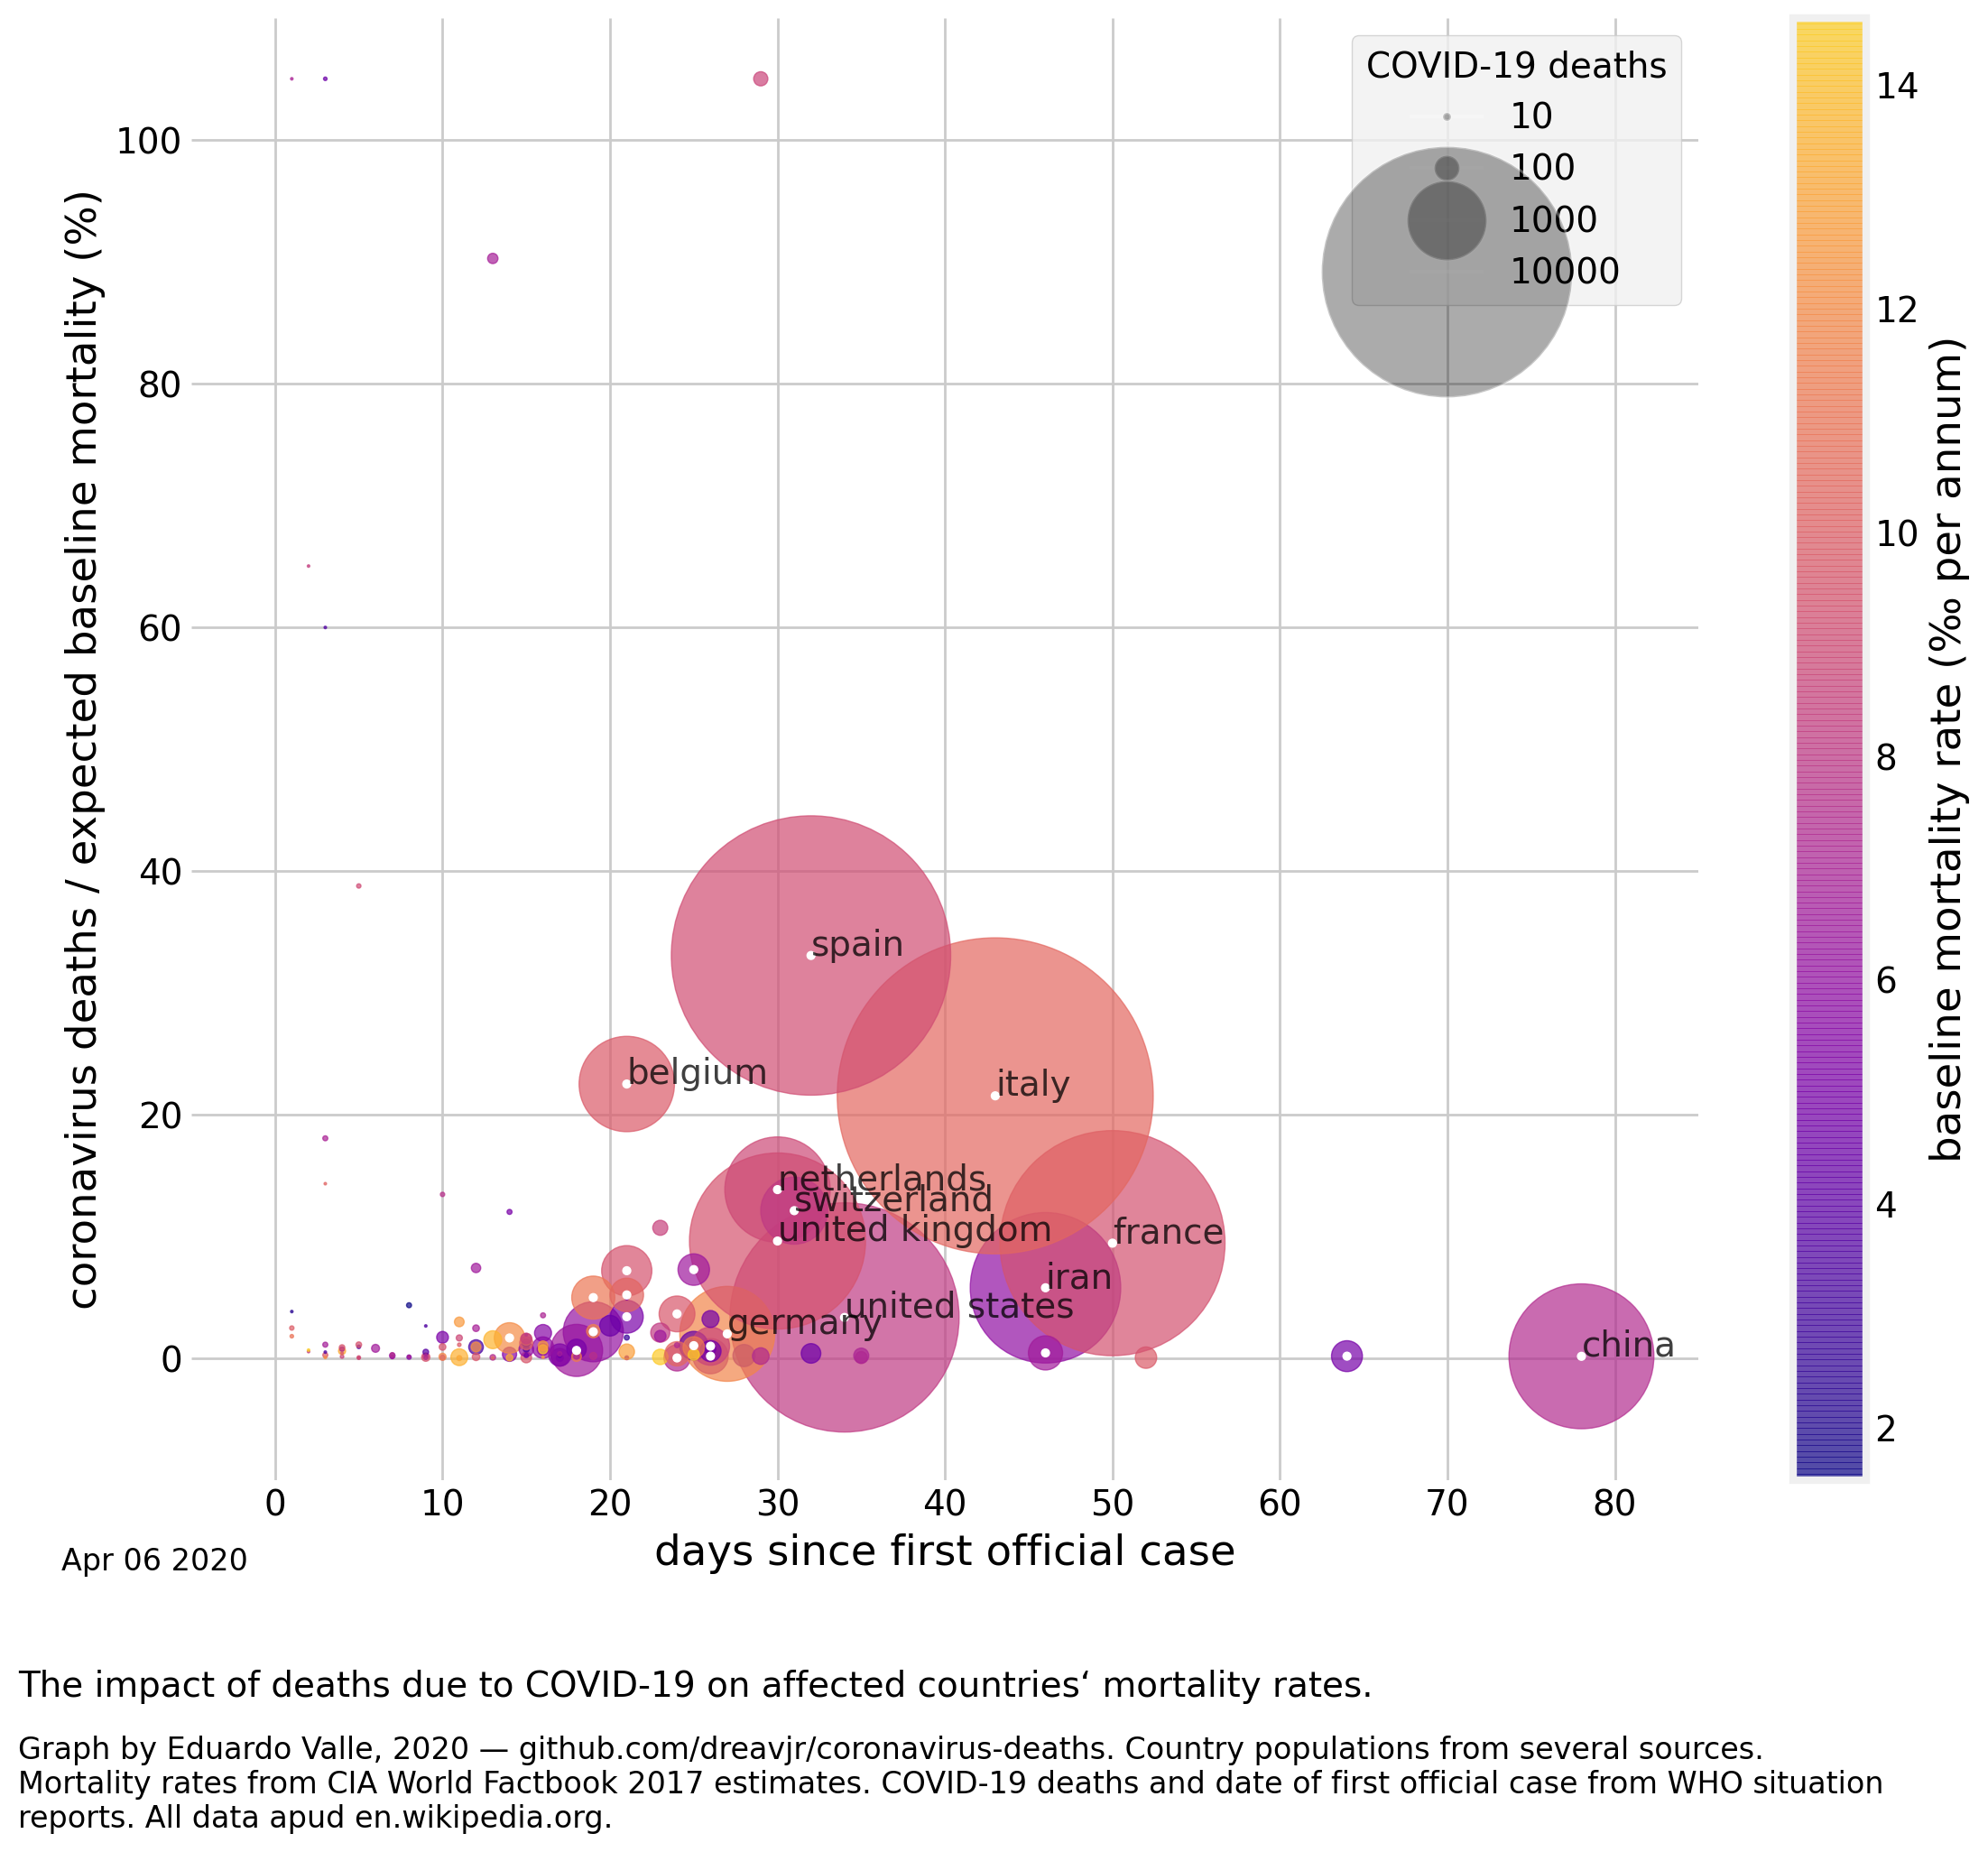

In [21]:
plot_frame(all_analyses[-1], save_figure='plot_main.png')

In [22]:
n_frames = len(all_analyses)
n_frames

79

In [23]:
%%capture

output_folder = 'plot_frames'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
# Prepares the frames for the animation --- this may take a long time
first_appearance = set()
image_names = []
for i,frame in enumerate(all_analyses + all_analyses[-1:]):
    frame_name = os.path.join(output_folder, f'frame_{i:03}.png')
    plot_frame(frame, first_appearance, save_figure=frame_name, fig_dpi=100, animation=True)
    image_names.append(frame_name)

In [24]:
# These imports are separated because they're not necessary to prepare the static plots 
# nor the individual frames for the animation
import imageio
from pygifsicle import gifsicle

In [25]:
animated_output_file = 'plot_animated_pre.gif'
frame_duration = 0.12 # in seconds
last_frame_duration = 5.

frame_durations = [ frame_duration ] * (len(image_names)-1) + [ last_frame_duration ]
image_frames = [ imageio.imread(i_n) for i_n in image_names ]

#imageio.mimwrite(output_file_name, image_frames, format='GIF-FI', duration=float or [float]*n_frames or fps=, loop=times or 0 for infinite, palettesize=2**{1 to 8}, quantizer={‘wu’, ‘nq’}, subrectangles=True would save only changing parts but appears to be broken) 
imageio.mimwrite(animated_output_file, image_frames, duration=frame_durations, loop=0, palettesize=256)

In [26]:
animated_optimized_file = 'plot_animated.gif'
# options here: https://www.lcdf.org/gifsicle/man.html
gifsicle(
    sources=animated_output_file,
    destination=animated_optimized_file,
    optimize=True,
    colors=256, # Always a power of two
    options=[# "--dither",
            ]
    )